In [12]:
from abc import ABC, abstractmethod
import os
import pickle
import collections
import numpy as np
import random


class Learner(ABC):
    """
    Parent class for Q-learning and SARSA agents.

    Parameters
    ----------
    alpha : float
        learning rate
    gamma : float
        temporal discounting rate
    eps : float
        probability of random action vs. greedy action
    eps_decay : float
        epsilon decay rate. Larger value = more decay
    """
    def __init__(self, alpha, gamma, eps, eps_decay=0., size=3):
        # Agent parameters
        self.size = size
        self.alpha = alpha
        self.gamma = gamma
        self.eps = eps
        self.eps_decay = eps_decay
        # Possible actions correspond to the set of all x,y coordinate pairs
        self.actions = []
        for i in range(size):
            for j in range(size):
                self.actions.append((i,j))
        # Initialize Q values to 0 for all state-action pairs.
        # Access value for action a, state s via Q[a][s]
        self.Q = {}
        for action in self.actions:
            self.Q[action] = collections.defaultdict(int)
        # Keep a list of reward received at each episode
        self.rewards = []

    def get_action(self, s):
        """
        Select an action given the current game state.

        Parameters
        ----------
        s : string
            state
        """
        # Only consider the allowed actions (empty board spaces)
        possible_actions = [a for a in self.actions if s[a[0]*self.size + a[1]] == '-']
        if random.random() < self.eps:
            # Random choose.
            action = possible_actions[random.randint(0,len(possible_actions)-1)]
        else:
            # Greedy choose.
            values = np.array([self.Q[a][s] for a in possible_actions])
            # Find location of max
            ix_max = np.where(values == np.max(values))[0]
            if len(ix_max) > 1:
                # If multiple actions were max, then sample from them
                ix_select = np.random.choice(ix_max, 1)[0]
            else:
                # If unique max action, select that one
                ix_select = ix_max[0]
            action = possible_actions[ix_select]

        # update epsilon; geometric decay
        self.eps *= (1.-self.eps_decay)

        return action

    def save(self, path):
        """ Pickle the agent object instance to save the agent's state. """
        if os.path.isfile(path):
            os.remove(path)
        f = open(path, 'wb')
        pickle.dump(self, f)
        f.close()

    @abstractmethod
    def update(self, s, s_, a, a_, r):
        pass

    @abstractmethod
    def update_by_episode(self, episode):
        pass


class MonteCarlo(Learner):

    def __init__(self, alpha, gamma, eps, eps_decay=0., size=3):
        super().__init__(alpha, gamma, eps, eps_decay, size)
        self.N = collections.defaultdict(int)

    def update(self, s, s_, a, a_, r):
        self.N[s] += 1
        self.Q[a][s] += 1 / self.N[s] * (r + self.gamma * self.Q[a_][s_] - self.Q[a][s])

    def update_by_episode(self, episode):
        episode = episode[::-1]

        for i in range(len(episode) - 1):
            s, a, s_, r = episode[i]
            a_ = episode[i + 1][1]
            self.update(s, s_, a, a_, r)
        self.rewards.append(episode[0][3])

class Qlearner(Learner):
    """
    A class to implement the Q-learning agent.
    """
    def __init__(self, alpha, gamma, eps, eps_decay=0.,size=None):
        super().__init__(alpha, gamma, eps, eps_decay,size)

    def update(self, s, s_, a, a_, r):
        """
        Perform the Q-Learning update of Q values.

        Parameters
        ----------
        s : string
            previous state
        s_ : string
            new state
        a : (i,j) tuple
            previous action
        a_ : (i,j) tuple
            new action. NOT used by Q-learner!
        r : int
            reward received after executing action "a" in state "s"
        """
        # Update Q(s,a)
        if s_ is not None:
            # hold list of Q values for all a_,s_ pairs. We will access the max later
            possible_actions = [action for action in self.actions if s_[action[0]*self.size + action[1]] == '-']
            Q_options = [self.Q[action][s_] for action in possible_actions]
            # update
            self.Q[a][s] += self.alpha*(r + self.gamma*max(Q_options) - self.Q[a][s])
        else:
            # terminal state update
            self.Q[a][s] += self.alpha*(r - self.Q[a][s])

        # add r to rewards list
        self.rewards.append(r)
    def update_by_episode(self, episode):
        """
        Updates the Q-values based on an entire episode of experience.

        Parameters
        ----------
        episode : list of tuples
            A list of (state, action, next_state, reward) tuples representing the episode.
        """
        # Iterate through the episode and update Q-values
        for i in range(len(episode) - 1):
            s, a, s_, r = episode[i]

            # Get the next action from the episode
            a_ = episode[i + 1][1]

            # Perform the Q-learning update
            self.update(s, s_, a, a_, r)

        # Append the reward from the last step of the episode
        self.rewards.append(episode[-1][3]) # Append the reward for the final state

class SARSAlearner(Learner):
    """
    A class to implement the SARSA agent.
    """
    def __init__(self, alpha, gamma, eps, eps_decay=0.,size=None):
        super().__init__(alpha, gamma, eps, eps_decay, size)

    def update(self, s, s_, a, a_, r):
        """
        Perform the SARSA update of Q values.

        Parameters
        ----------
        s : string
            previous state
        s_ : string
            new state
        a : (i,j) tuple
            previous action
        a_ : (i,j) tuple
            new action
        r : int
            reward received after executing action "a" in state "s"
        """
        # Update Q(s,a)
        if s_ is not None:
            self.Q[a][s] += self.alpha*(r + self.gamma*self.Q[a_][s_] - self.Q[a][s])
        else:
            # terminal state update
            self.Q[a][s] += self.alpha*(r - self.Q[a][s])

        # add r to rewards list
        self.rewards.append(r)

    def update_by_episode(self, episode):
        """
        Updates the Q-values based on an entire episode of experience.

        Parameters
        ----------
        episode : list of tuples
            A list of (state, action, next_state, reward) tuples representing the episode.
        """
        # Implement SARSA update logic here for the entire episode
        # This is just a placeholder, you need to implement the actual logic
        for i in range(len(episode) - 1):
            s, a, s_, r = episode[i]

            # Get the next action (a_) from the next step in the episode
            a_ = episode[i + 1][1]

            # Now perform the SARSA update
            self.update(s, s_, a, a_, r)

        # Append the reward from the last step of the episode
        self.rewards.append(episode[-1][-1])


In [2]:
import random

class Game:

    def __init__(self, agent_1, agent_2, size=3):
        self.agent_1 = agent_1
        self.agent_2 = agent_2
        self.size = size
        self.board = [['-' for _ in range(size)] for _ in range(size)]


    def agent1Move(self, action):
        self.board[action[0]][action[1]] = 'O'

    def agent2Move(self, action):
        self.board[action[0]][action[1]] = 'X'

    def checkForWin(self, key):

        diag1 = [self.board[i][i] for i in range(self.size)]
        diag2 = [self.board[i][self.size - i - 1] for i in range(self.size)]
        if diag1.count(key) == self.size or diag2.count(key) == self.size:
            return True

        for i in range(self.size):
            row = [self.board[i][j] for j in range(self.size)]
            col = [self.board[j][i] for j in range(self.size)]
            if row.count(key) == self.size or col.count(key) == self.size:
                return True

        return False

    def checkForDraw(self):
        return all(elt != '-' for row in self.board for elt in row)

    def checkForEnd(self, key):
        if self.checkForWin(key):
            return 1
        elif self.checkForDraw():
            return 0
        return -1

    def playGame(self):
        agent1_episode = []
        agent2_episode = []
        agent1_prev_state = getStateKey(self.board)
        agent1_action = self.agent_1.get_action(agent1_prev_state)
        self.agent1Move(agent1_action)
        while True:
            agent2_prev_state = getStateKey(self.board)
            agent2_action = self.agent_2.get_action(agent2_prev_state)
            self.agent2Move(agent2_action)
            if self.checkForEnd('X') != -1:
                reward = self.checkForEnd('X')
                agent1_episode.append((agent1_prev_state, agent1_action, agent2_prev_state, -reward))
                agent2_episode.append((agent2_prev_state, agent2_action, getStateKey(self.board), reward))
                break
            else:
                reward = 0
                agent1_episode.append((agent1_prev_state, agent1_action, agent2_prev_state, reward))
            agent1_prev_state = getStateKey(self.board)
            agent1_action = self.agent_1.get_action(agent1_prev_state)
            self.agent1Move(agent1_action)
            if self.checkForEnd('O') != -1:
                reward = self.checkForEnd('O')
                agent1_episode.append((agent1_prev_state, agent1_action, getStateKey(self.board), reward))
                agent2_episode.append((agent2_prev_state, agent2_action, agent1_prev_state, -reward))
                break
            else:
                reward = 0
                agent2_episode.append((agent2_prev_state, agent2_action, agent1_prev_state, reward))

        self.agent_1.update_by_episode(agent1_episode)
        self.agent_2.update_by_episode(agent2_episode)
        print(agent1_episode)
        print(agent2_episode)
        print("-"*100)


    def start(self, episodes=1000):
        for _ in range(episodes):
            print(f"{_}:")
            self.playGame()
            self.board = [['-' for _ in range(self.size)] for _ in range(self.size)]
        self.agent_1.save('agent_1.pkl')
        self.agent_2.save('agent_2.pkl')



def printBoard(board, size):
    """
    Prints the game board as text output to the terminal.

    Parameters
    ----------
    board : list of lists
        the current game board
    size : int
        the size of the board (3, 4, or 5)
    """
    header = '    ' + '   '.join(str(i) for i in range(size))
    print(header + '\n')
    for i, row in enumerate(board):
        print('%i   ' % i, end='')
        for elt in row:
            print('%s   ' % elt, end='')
        print('\n')


def getStateKey(board):
    """
    Converts 2D list representing the board state into a string key
    for that state. Keys are used for Q-value hashing.

    Parameters
    ----------
    board : list of lists
        the current game board
    """
    return ''.join(''.join(row) for row in board)

In [13]:
agent1 = SARSAlearner(alpha=0.5, gamma=0.9, eps=0.1, size=4)
agent2 = Qlearner(alpha=0.5, gamma=0.9, eps=0.1, size=4)
game = Game(agent_1=agent1, agent_2=agent2, size=4)

print(game.start(10000))

Streaming output truncated to the last 5000 lines.
[('----------------', (3, 3), '---------------O', 0), ('-------X-------O', (0, 0), 'O------X-------O', 0), ('O--X---X-------O', (1, 1), 'O--X-O-X-------O', 0), ('O--X-O-X-X-----O', (1, 0), 'O--XOO-X-X-----O', 0), ('O--XOO-X-X--X--O', (2, 0), 'O--XOO-XOX--X--O', 0), ('O--XOO-XOXX-X--O', (2, 3), 'O--XOO-XOXXOX--O', 0), ('O--XOO-XOXXOX-XO', (3, 1), 'O--XOO-XOXXOXOXO', 0), ('O-XXOO-XOXXOXOXO', (1, 2), 'O-XXOOOXOXXOXOXO', 0)]
[('---------------O', (1, 3), '-------X-------O', 0), ('O------X-------O', (0, 3), 'O--X---X-------O', 0), ('O--X-O-X-------O', (2, 1), 'O--X-O-X-X-----O', 0), ('O--XOO-X-X-----O', (3, 0), 'O--XOO-X-X--X--O', 0), ('O--XOO-XOX--X--O', (2, 2), 'O--XOO-XOXX-X--O', 0), ('O--XOO-XOXXOX--O', (3, 2), 'O--XOO-XOXXOX-XO', 0), ('O--XOO-XOXXOXOXO', (0, 2), 'O-XXOO-XOXXOXOXO', 0), ('O-XXOOOXOXXOXOXO', (0, 1), 'OXXXOOOXOXXOXOXO', 0)]
---------------------------------------------------------------------------------------------------

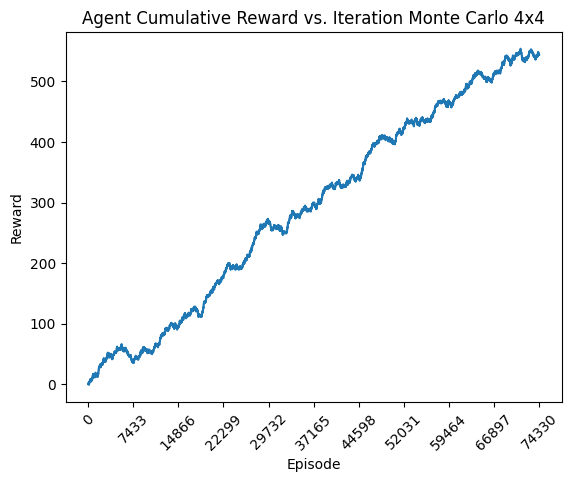

In [14]:
import os
import pickle
import sys
import numpy as np
import matplotlib.pylab as plt

with open("agent_1.pkl", 'rb') as f:
    agent = pickle.load(f)

def plot_agent_reward(rewards):
    """ Function to plot agent's accumulated reward vs. iteration """

    # Plot cumulative rewards
    plt.plot(np.cumsum(rewards))

    # Set the title and labels
    plt.title('Agent Cumulative Reward vs. Iteration Monte Carlo 4x4')
    plt.ylabel('Reward')
    plt.xlabel('Episode')

    # Improve x-axis by adding more ticks
    num_episodes = len(rewards)
    plt.xticks(np.arange(0, num_episodes, step=max(1, num_episodes // 10)))  # Adjust the step to control tick frequency

    # Optionally, rotate x-tick labels if they overlap
    plt.xticks(rotation=45)

    # Show the plot
    plt.show()
plot_agent_reward(agent.rewards)
